## import & load

In [45]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

import datetime
import pytz
import importlib
import matplotlib.pyplot as plt

import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [46]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

In [47]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')
    os.environ["GOOGLE_CLOUD_PROJECT"] = "trading-290017"
else:
    print('the credential.json file does not exist')

import importlib

In [48]:
import market_data.ingest.bq.cache
importlib.reload(market_data.ingest.bq.common)
importlib.reload(market_data.ingest.bq.cache)

<module 'market_data.ingest.bq.cache' from '/Users/junlim/projects/jitter_recovery/market_data/ingest/bq/cache.py'>

In [49]:
date_str_from='2024-04-01'
date_str_to='2024-04-14'
dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX
export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE

In [50]:
df = market_data.ingest.bq.cache.fetch_and_cache(
    dataset_mode, 
    export_mode, 
    market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from=date_str_from, date_str_to=date_str_to).reset_index()
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])

In [51]:
all_symbols = df.symbol.unique()
all_symbols = [s for s in all_symbols if s]
len([s for s in all_symbols if 'USDT' in s])

185

## calculate/cache feature

In [52]:
import algo.feature.momentum.calculate
importlib.reload(algo.feature.momentum.calculate)
import algo.feature.momentum.research
importlib.reload(algo.feature.momentum.research)
import algo.cache
importlib.reload(algo.cache)

<module 'algo.cache' from '/Users/junlim/projects/jitter_recovery/algo/cache.py'>

In [62]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(
    window=360, ema_window=60, 
    filter_out_non_gemini_symbol=False, filter_out_reportable_symbols=False)

In [63]:
algo.feature.momentum.research.get_feature_label_for_caching(feature_param)

'feature/(momentum)_window(360)_ema_window(60)'

In [ ]:
dfst_feature = algo.feature.momentum.research.get_dfst_feature(
    df, feature_param, w_gemini_coins_only=True, filter_out_reportable_symbols=True,
    symbol_filter=lambda s: s.endswith('USD'))

before filtering out any symbols: 91
after filtering out non-gemini symbols: 91
after filtering out reportable symbols: 79
before applying the symbol_filter: 79
all_symbols: 62
0 symbol: AAVEUSD (feature)
1 symbol: ALIUSD (feature)
2 symbol: ANKRUSD (feature)
3 symbol: APEUSD (feature)
4 symbol: API3USD (feature)
5 symbol: AVAXUSD (feature)
6 symbol: BATUSD (feature)
7 symbol: BCHUSD (feature)
8 symbol: BTCGUSD (feature)
9 symbol: BTCUSD (feature)
10 symbol: COMPUSD (feature)
11 symbol: CRVUSD (feature)
12 symbol: CTXUSD (feature)
13 symbol: CUBEUSD (feature)
14 symbol: DAIUSD (feature)
15 symbol: DOGEUSD (feature)
16 symbol: DOTUSD (feature)
17 symbol: ELONUSD (feature)
18 symbol: ENSUSD (feature)
19 symbol: ERNUSD (feature)
20 symbol: ETHGUSD (feature)
21 symbol: ETHUSD (feature)
22 symbol: FETUSD (feature)
23 symbol: FTMUSD (feature)
24 symbol: GALAUSD (feature)
25 symbol: GALUSD (feature)
26 symbol: GMTUSD (feature)
27 symbol: GRTUSD (feature)
28 symbol: HNTUSD (feature)
29 symbol:

In [166]:
dfst_feature = algo.cache.read_df(
    label = algo.feature.momentum.research.get_feature_label_for_caching(feature_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-03-15', 
    date_str_to='2024-03-23')

In [167]:
algo.feature.momentum.research.get_feature_label_for_caching(feature_param)

'feature/(momentum)_window(360)_ema_window(60)'

In [168]:
dfst_feature.columns

Index(['index', 'open', 'high', 'low', 'close', 'volume', 'value', 'ema', 'ch',
       'ch_ema', 'momentum', 'rank', 'rank_descending'],
      dtype='object')

In [169]:
dfst_feature.index.get_level_values('symbol').unique().shape

(212,)

## multiple symbols

In [141]:
import algo.alpha.momentum.calculate
importlib.reload(algo.alpha.momentum.calculate)
import algo.alpha.momentum.research
importlib.reload(algo.alpha.momentum.research)

<module 'algo.alpha.momentum.research' from '/Users/junlim/projects/jitter_recovery/algo/alpha/momentum/research.py'>

In [170]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(
    window=360, ema_window=60, 
    filter_out_non_gemini_symbol=False, filter_out_reportable_symbols=False)
trading_param = algo.alpha.momentum.calculate.MomentumTradingParam(
    feature_param, selection_size=5, rebalance_interval_minutes=6*60)

In [171]:
algo.alpha.momentum.research.get_trading_label_for_caching(trading_param)

'trading/(momentum_trading)_feature_param(window(360)_ema_window(60))_selection_size(5)_rebalance_interval_minutes(360)'

In [172]:
dfst_trading = algo.alpha.momentum.research.get_dfst_trading(dfst_feature, trading_param)

symbol_with_momentums: 144
0 symbol: ACH-USDT-SWAP: (trading)
1 symbol: AEVO-USDT-SWAP: (trading)
2 symbol: AGIX-USDT-SWAP: (trading)
3 symbol: AGLD-USDT-SWAP: (trading)
4 symbol: AIDOGE-USDT-SWAP: (trading)
5 symbol: APT-USDT-SWAP: (trading)
6 symbol: AR-USDT-SWAP: (trading)
7 symbol: AUCTION-USDT-SWAP: (trading)
8 symbol: AVAX-USDT-SWAP: (trading)
9 symbol: BICO-USDT-SWAP: (trading)
10 symbol: BIGTIME-USDT-SWAP: (trading)
11 symbol: BONE-USDT-SWAP: (trading)
12 symbol: BONK-USDT-SWAP: (trading)
13 symbol: BSV-USDT-SWAP: (trading)
14 symbol: CELO-USDT-SWAP: (trading)
15 symbol: CETUS-USDT-SWAP: (trading)
16 symbol: CFX-USDT-SWAP: (trading)
17 symbol: DGB-USDT-SWAP: (trading)
18 symbol: DMAIL-USDT-SWAP: (trading)
19 symbol: EGLD-USDT-SWAP: (trading)
20 symbol: ETHW-USDT-SWAP: (trading)
21 symbol: FET-USDT-SWAP: (trading)
22 symbol: FITFI-USDT-SWAP: (trading)
23 symbol: FLOKI-USDT-SWAP: (trading)
24 symbol: FRONT-USDT-SWAP: (trading)
25 symbol: FTM-USDT-SWAP: (trading)
26 symbol: GAL-US

In [174]:
fee_pct = 0.05
spread_pct = 0.1
num_trades = len(dfst_trading[(dfst_trading.position_changed != 0)].dropna())
gross_profit = round(dfst_trading[['profit']].dropna().groupby('timestamp').sum().sum().profit, 2)
cost = round(num_trades * 0.01 * (fee_pct + spread_pct), 2)
print(f'{gross_profit=}, {cost=}, net: {round(gross_profit-cost, 2)}')

gross_profit=0.95, cost=0.87, net: 0.08


187


<AxesSubplot:xlabel='timestamp'>

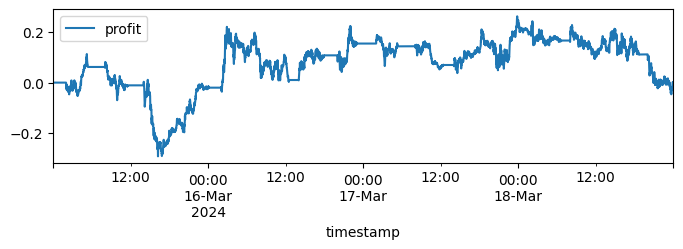

In [165]:
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

581


<AxesSubplot:xlabel='timestamp'>

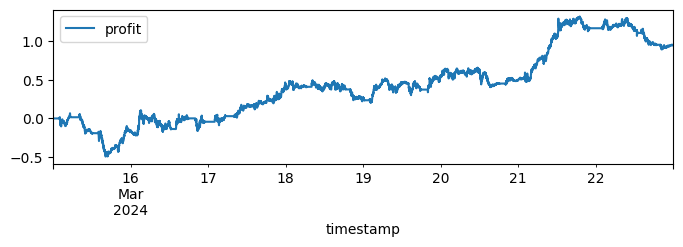

In [173]:
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

63


<AxesSubplot:xlabel='timestamp'>

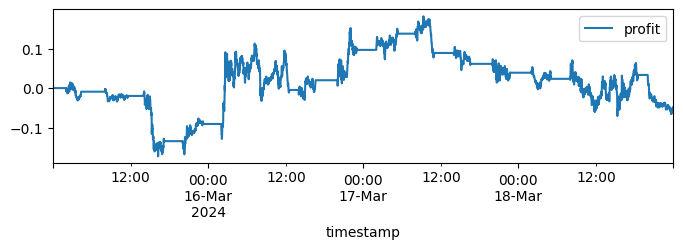

In [140]:
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

31


<AxesSubplot:xlabel='timestamp'>

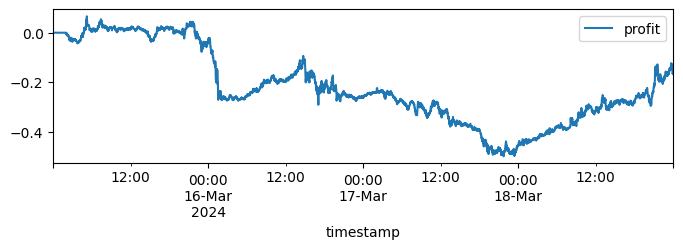

In [89]:
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

58


<AxesSubplot:xlabel='timestamp'>

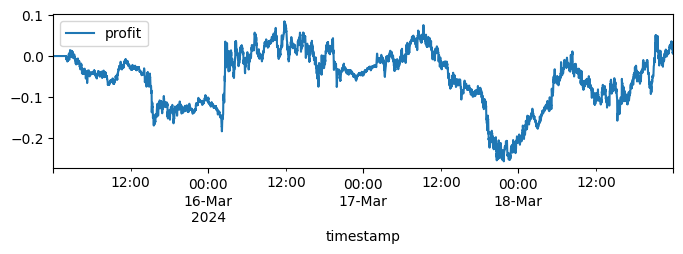

In [72]:
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [90]:
dfst_trading[
    (dfst_trading.profit != 0)
][['profit', 'in_position', 'rank_descending']].dropna()

profit  in_position  \
symbol         timestamp                                          
AGLD-USDT-SWAP 2024-03-15 08:01:00-04:00  0.002686         -1.0   
               2024-03-15 08:02:00-04:00 -0.004040         -1.0   
               2024-03-15 08:03:00-04:00 -0.002012         -1.0   
               2024-03-15 08:04:00-04:00  0.002008         -1.0   
               2024-03-15 08:05:00-04:00  0.002683         -1.0   
...                                            ...          ...   
RAY-USDT-SWAP  2024-03-18 23:55:00-04:00 -0.002448         -1.0   
               2024-03-18 23:56:00-04:00  0.000692         -1.0   
               2024-03-18 23:57:00-04:00 -0.000937         -1.0   
               2024-03-18 23:58:00-04:00  0.005574         -1.0   
               2024-03-18 23:59:00-04:00 -0.000655         -1.0   

                                          rank_descending  
symbol         timestamp                                   
AGLD-USDT-SWAP 2024-03-15 08:01:00-04:00            177.0  
               2024-03-15 08:02:00-04:00            177.0  
               2024-03-15 08:03:00-04:00            177.0  
               2024-03-15 08:04:00-04:00            177.0  
               2024-03-15 08:05:00-04:00            177.0  
...                                                   ...  
RAY-USDT-SWAP  2024-03-18 23:55:00-04:00            176.0  
               2024-03-18 23:56:00-04:00            176.0  
               2024-03-18 23:57:00-04:00            176.0  
               2024-03-18 23:58:00-04:00            176.0  
               2024-03-18 23:59:00-04:00            176.0  

[5364 rows x 3 columns]

In [83]:
dfst_trading[
    (dfst_trading.profit != 0)
][['profit', 'in_position', 'rank_descending']].dropna()

profit  in_position  \
symbol         timestamp                                          
AGLD-USDT-SWAP 2024-03-15 08:01:00-04:00  0.002686         -1.0   
               2024-03-15 08:02:00-04:00 -0.004040         -1.0   
               2024-03-15 08:03:00-04:00 -0.002012         -1.0   
               2024-03-15 08:04:00-04:00  0.002008         -1.0   
               2024-03-15 08:05:00-04:00  0.002683         -1.0   
...                                            ...          ...   
XRP-USDT-SWAP  2024-03-18 23:55:00-04:00 -0.001299          1.0   
               2024-03-18 23:56:00-04:00  0.000325          1.0   
               2024-03-18 23:57:00-04:00  0.000650          1.0   
               2024-03-18 23:58:00-04:00 -0.000325          1.0   
               2024-03-18 23:59:00-04:00 -0.000487          1.0   

                                          rank_descending  
symbol         timestamp                                   
AGLD-USDT-SWAP 2024-03-15 08:01:00-04:00            177.0  
               2024-03-15 08:02:00-04:00            177.0  
               2024-03-15 08:03:00-04:00            177.0  
               2024-03-15 08:04:00-04:00            177.0  
               2024-03-15 08:05:00-04:00            177.0  
...                                                   ...  
XRP-USDT-SWAP  2024-03-18 23:55:00-04:00              2.0  
               2024-03-18 23:56:00-04:00              2.0  
               2024-03-18 23:57:00-04:00              2.0  
               2024-03-18 23:58:00-04:00              2.0  
               2024-03-18 23:59:00-04:00              3.0  

[10174 rows x 3 columns]

In [128]:
dfst_trading[
    dfst_trading.in_position == -1
]

index    open    high     low  \
symbol         timestamp                                                    
AGLD-USDT-SWAP 2024-03-15 08:01:00-04:00   391127  1.4880  1.4900  1.4850   
               2024-03-15 08:02:00-04:00   391128  1.4850  1.4930  1.4820   
               2024-03-15 08:03:00-04:00   391129  1.4910  1.4950  1.4890   
               2024-03-15 08:04:00-04:00   391130  1.4940  1.4960  1.4880   
               2024-03-15 08:05:00-04:00   391131  1.4910  1.4920  1.4860   
...                                           ...     ...     ...     ...   
RAY-USDT-SWAP  2024-03-18 23:55:00-04:00  6611116  2.4501  2.4600  2.4487   
               2024-03-18 23:56:00-04:00  6611117  2.4577  2.4600  2.4529   
               2024-03-18 23:57:00-04:00  6611118  2.4557  2.4631  2.4525   
               2024-03-18 23:58:00-04:00  6611119  2.4580  2.4590  2.4366   
               2024-03-18 23:59:00-04:00  6611120  2.4450  2.4500  2.4305   

                                           close   volume   value       ema  \
symbol         timestamp                                                      
AGLD-USDT-SWAP 2024-03-15 08:01:00-04:00  1.4850  21331.0  1.4850  1.487817   
               2024-03-15 08:02:00-04:00  1.4910  20072.0  1.4910  1.487921   
               2024-03-15 08:03:00-04:00  1.4940  38309.0  1.4940  1.488120   
               2024-03-15 08:04:00-04:00  1.4910  21175.0  1.4910  1.488215   
               2024-03-15 08:05:00-04:00  1.4870  16019.0  1.4870  1.488175   
...                                          ...      ...     ...       ...   
RAY-USDT-SWAP  2024-03-18 23:55:00-04:00  2.4574  22022.0  2.4574  2.426646   
               2024-03-18 23:56:00-04:00  2.4557  20352.0  2.4557  2.427599   
               2024-03-18 23:57:00-04:00  2.4580  16323.0  2.4580  2.428595   
               2024-03-18 23:58:00-04:00  2.4443  13582.0  2.4443  2.429110   
               2024-03-18 23:59:00-04:00  2.4459  18573.0  2.4459  2.429661   

                                                ch    ch_ema  momentum  rank  \
symbol         timestamp                                                       
AGLD-USDT-SWAP 2024-03-15 08:01:00-04:00 -0.092853 -0.091132 -0.091132   1.0   
               2024-03-15 08:02:00-04:00 -0.089188 -0.091068 -0.091068   1.0   
               2024-03-15 08:03:00-04:00 -0.083436 -0.087043 -0.087043   1.0   
               2024-03-15 08:04:00-04:00 -0.084715 -0.086424 -0.086424   1.0   
               2024-03-15 08:05:00-04:00 -0.086048 -0.085326 -0.085326   1.0   
...                                            ...       ...       ...   ...   
RAY-USDT-SWAP  2024-03-18 23:55:00-04:00 -0.106400 -0.117583 -0.117583   4.0   
               2024-03-18 23:56:00-04:00 -0.109770 -0.119957 -0.119957   4.0   
               2024-03-18 23:57:00-04:00 -0.107221 -0.117901 -0.117901   4.0   
               2024-03-18 23:58:00-04:00 -0.109739 -0.115272 -0.115272   4.0   
               2024-03-18 23:59:00-04:00 -0.108247 -0.114168 -0.114168   4.0   

                                          rank_descending  in_position  \
symbol         timestamp                                                 
AGLD-USDT-SWAP 2024-03-15 08:01:00-04:00            177.0         -1.0   
               2024-03-15 08:02:00-04:00            177.0         -1.0   
               2024-03-15 08:03:00-04:00            177.0         -1.0   
               2024-03-15 08:04:00-04:00            177.0         -1.0   
               2024-03-15 08:05:00-04:00            177.0         -1.0   
...                                                   ...          ...   
RAY-USDT-SWAP  2024-03-18 23:55:00-04:00            176.0         -1.0   
               2024-03-18 23:56:00-04:00            176.0         -1.0   
               2024-03-18 23:57:00-04:00            176.0         -1.0   
               2024-03-18 23:58:00-04:00            176.0         -1.0   
               2024-03-18 23:59:00-04:00            176.0         -1.0   

          

In [127]:
dfst_trading[
    dfst_trading.in_position == 1
][['in_position', 'rank']]

,,in_position,rank
symbol,timestamp,,


<AxesSubplot:xlabel='rank'>

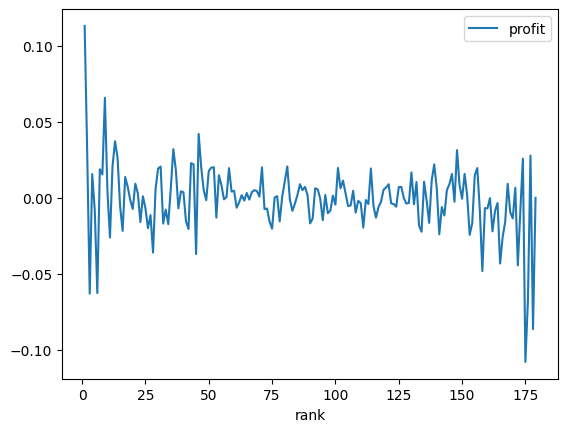

In [119]:
dfst_trading[['rank', 'profit']].dropna().groupby(['rank']).sum().plot()

<AxesSubplot:xlabel='rank'>

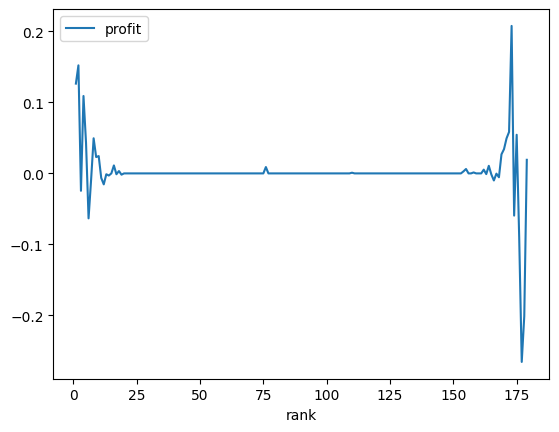

In [158]:
dfst_trading[['profit', 'rank']].dropna().groupby(['rank']).sum().plot()

<AxesSubplot:xlabel='rank'>

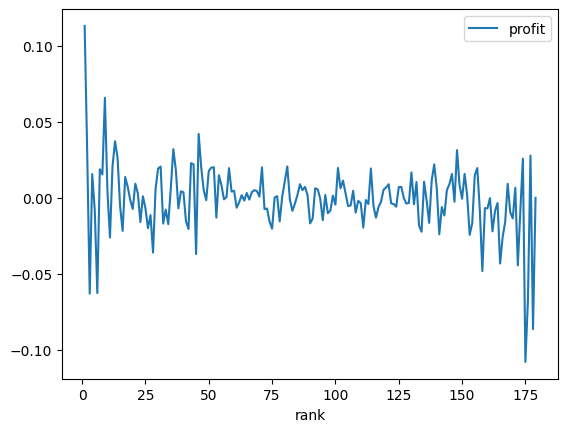

In [110]:
dfst_trading[['profit', 'rank']].dropna().groupby(['rank']).sum().plot()

<AxesSubplot:xlabel='rank'>

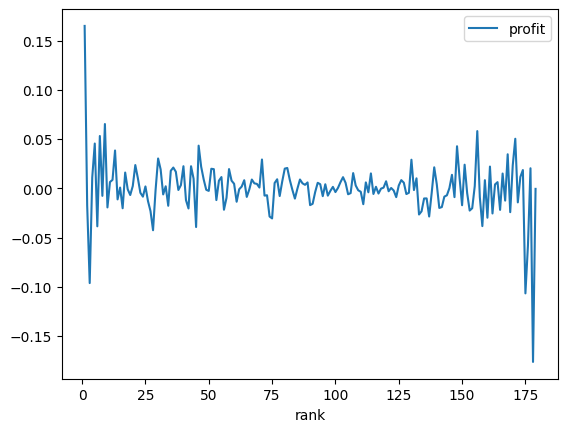

In [84]:
dfst_trading[['profit', 'rank']].dropna().groupby(['rank']).sum().plot()

In [74]:
dfst_trading.columns

Index(['index', 'open', 'high', 'low', 'close', 'volume', 'value', 'ema', 'ch',
       'ch_ema', 'momentum', 'rank', 'rank_descending', 'in_position',
       'value_at_enter', 'ch_from_enter', 'position_changed', 'profit_raw',
       'profit'],
      dtype='object')

In [70]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-03-14', 
    date_str_to='2024-03-19',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

2024-05-27 15:31:48,672 [MainThread  ] [INFO ]  filename='/Users/junlim/algo_cache/trading/(momentum_trading)_feature_param(window(360)_ema_window(60))_selection_size(1)_rebalance_interval_minutes(360)/trading-290017.market_data_okx.by_minute/2024-03-14T00:00:00-0400_2024-03-15T00:00:00-0400.parquet' does not exist in local cache. For gcs, blob_exist=False.
2024-05-27 15:31:48,675 [MainThread  ] [INFO ]  df_cache is None for (datetime.datetime(2024, 3, 14, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>), datetime.datetime(2024, 3, 15, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>))
2024-05-27 15:31:48,733 [MainThread  ] [INFO ]  filename='/Users/junlim/algo_cache/trading/(momentum_trading)_feature_param(window(360)_ema_window(60))_selection_size(1)_rebalance_interval_minutes(360)/trading-290017.market_data_okx.by_minute/2024-03-15T00:00:00-0400_2024-03-16T00:00:00-0400.parquet' does not exist in local cache. For gcs, blob_exist=False.
2024-05-

AttributeError: 'NoneType' object has no attribute 'position_changed'

2024-05-27 13:20:08,080 [MainThread  ] [INFO ]  filename='/Users/junlim/algo_cache/trading/(momentum_trading)_feature_param(window(120)_ema_window(30)_filter_out_non_gemini_symbol(True)_filter_out_reportable_symbols(True))_selection_size(1)_rebalance_interval_minutes(60)/trading-290017.market_data_okx.by_minute/2024-04-01T00:00:00-0400_2024-04-02T00:00:00-0400.parquet' does not exist in local cache. For gcs, blob_exist=False.
2024-05-27 13:20:08,081 [MainThread  ] [INFO ]  df_cache is None for (datetime.datetime(2024, 4, 1, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>), datetime.datetime(2024, 4, 2, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>))
1696


<AxesSubplot:xlabel='timestamp'>

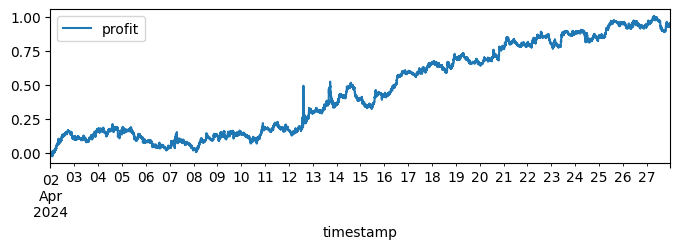

In [39]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-02', 
    date_str_to='2024-04-28',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [126]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(window=360, ema_window=60)
trading_param = algo.alpha.momentum.calculate.MomentumTradingParam(
    feature_param, selection_size=2, rebalance_interval_minutes=6*60)

In [127]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-03-03', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

1791


<AxesSubplot:xlabel='timestamp'>

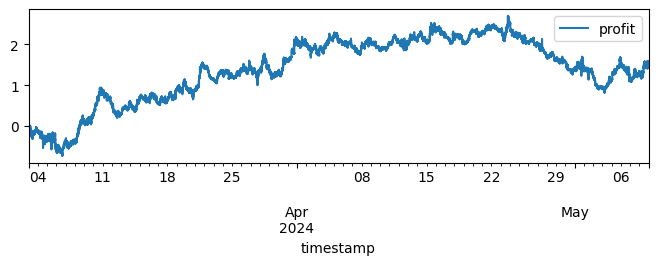

In [128]:
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

983


<AxesSubplot:xlabel='timestamp'>

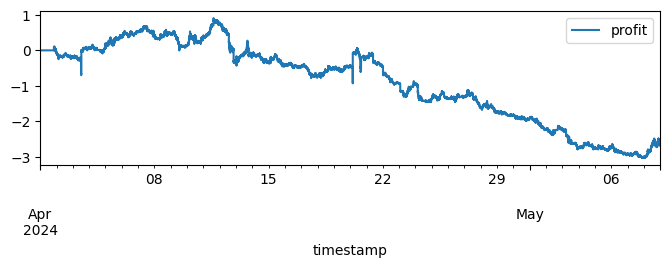

In [13]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.CEX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-01', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

891


<AxesSubplot:xlabel='timestamp'>

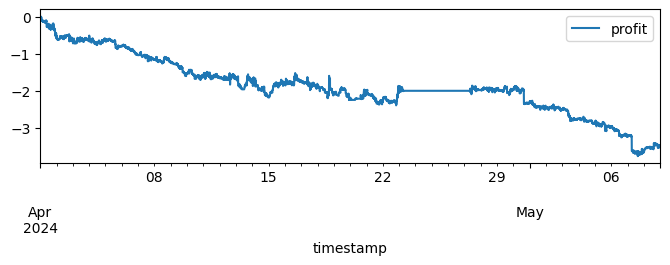

In [14]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.GEMINI,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-01', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

934


<AxesSubplot:xlabel='timestamp'>

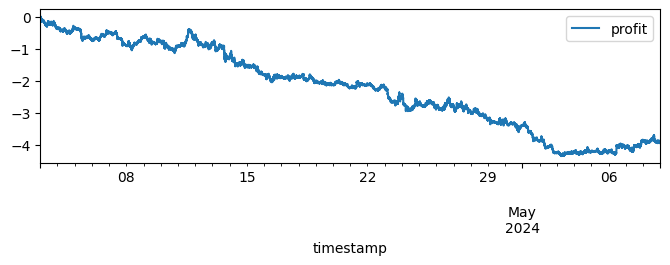

In [52]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.BITHUMB,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.ORDERBOOK_LEVEL1,
    date_str_from='2024-04-03', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [47]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(window=180, ema_window=30)
trading_param = algo.alpha.momentum.calculate.MomentumTradingParam(
    feature_param, selection_size=2, rebalance_interval_minutes=3*60)

3502


<AxesSubplot:xlabel='timestamp'>

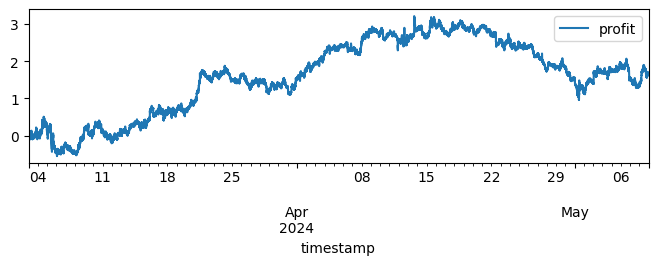

In [21]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-03-03', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

1926


<AxesSubplot:xlabel='timestamp'>

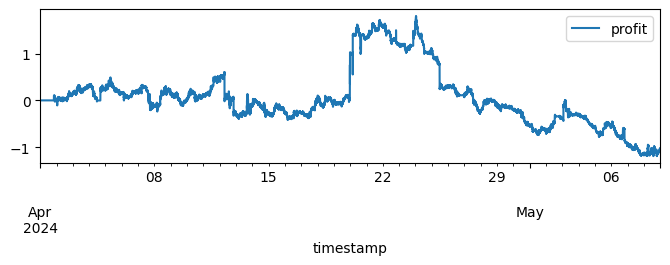

In [22]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.CEX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-01', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

1743


<AxesSubplot:xlabel='timestamp'>

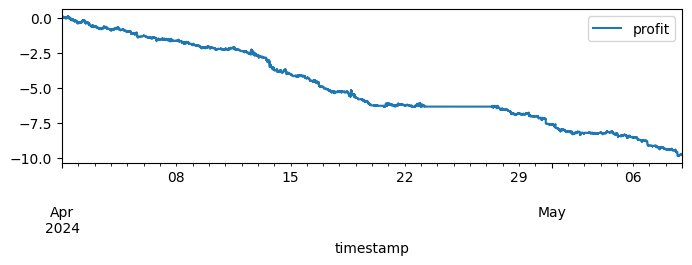

In [23]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.GEMINI,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-01', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

1977


<AxesSubplot:xlabel='timestamp'>

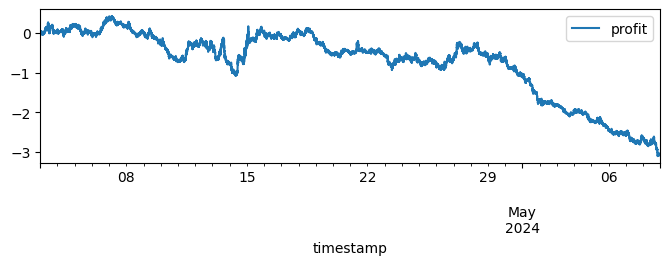

In [48]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.BITHUMB,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.ORDERBOOK_LEVEL1,
    date_str_from='2024-04-03', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [1058]:
dfst_trading[
    dfst_trading.in_position == 1
][['in_position']].groupby('timestamp').sum().plot(figsize=(8,1))

AttributeError: 'DataFrame' object has no attribute 'in_position'

<AxesSubplot:xlabel='timestamp'>

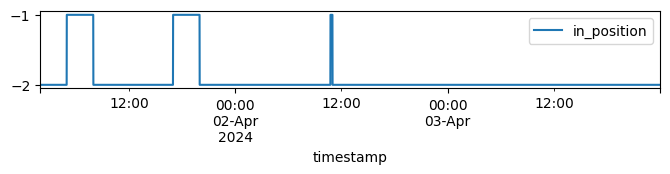

In [981]:
dfst_trading[
    dfst_trading.in_position == -1
][['in_position']].groupby('timestamp').sum().plot(figsize=(8,1))

<AxesSubplot:xlabel='timestamp'>

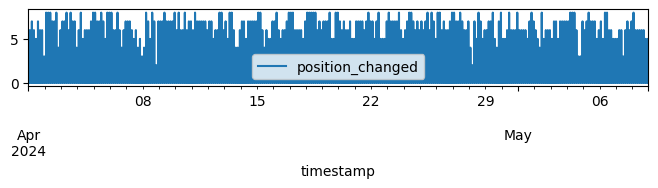

In [1060]:
dfst_trading[['position_changed']].abs().groupby('timestamp').sum().plot(figsize=(8,1))

In [1061]:
dfst_trading.columns

Index(['profit', 'value', 'position_changed'], dtype='object')

In [1062]:
len(dfst_trading[dfst_trading.profit.fillna(0) != 0][['profit']].groupby('symbol').sum().sort_values('profit'))

147

In [26]:
dfst_trading[dfst_trading.profit.fillna(0) != 0][['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
QRDOUSD,-2.125710
LUNAUSD,-0.930137
ERNUSD,-0.876574
ZBCUSD,-0.699040
ALIUSD,-0.649819
...,...
API3USD,0.040561
OXTUSD,0.050041
IOTXUSD,0.061196


In [985]:
len(dfst_trading[(dfst_trading.position_changed != 0)].dropna())

164

In [986]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-04-01 02:00:00-04:00, JOE-USDT-SWAP, 0.843, position_changed: -1.0
2024-04-01 02:00:00-04:00, LQTY-USDT-SWAP, 2.003, position_changed: 1.0
2024-04-01 02:00:00-04:00, RAY-USDT-SWAP, 2.2908, position_changed: -1.0
2024-04-01 02:00:00-04:00, RVN-USDT-SWAP, 0.05145, position_changed: 1.0
2024-04-01 04:21:00-04:00, RVN-USDT-SWAP, 0.04754, position_changed: -1.0
2024-04-01 05:00:00-04:00, JOE-USDT-SWAP, 0.8753, position_changed: 1.0
2024-04-01 05:00:00-04:00, CORE-USDT-SWAP, 2.6991, position_changed: 1.0
2024-04-01 05:00:00-04:00, RAY-USDT-SWAP, 2.3258, position_changed: 1.0
2024-04-01 05:00:00-04:00, RVN-USDT-SWAP, 0.04778, position_changed: -1.0
2024-04-01 05:00:00-04:00, LQTY-USDT-SWAP, 1.88, position_changed: -1.0
2024-04-01 05:00:00-04:00, DGB-USDT-SWAP, 0.020195, position_changed: 1.0
2024-04-01 07:47:00-04:00, DGB-USDT-SWAP, 0.018109, position_changed: -1.0
2024-04-01 08:00:00-04:00, DGB-USDT-SWAP, 0.018132, position_changed: -1.0
2024-04-01 08:00:00-04:00, SUI-USDT-SWAP, 1.966, 

## momentum reversal

In [99]:
import algo.alpha.momentum_reversal.calculate
importlib.reload(algo.alpha.momentum_reversal.calculate)
import algo.alpha.momentum_reversal.research
importlib.reload(algo.alpha.momentum_reversal.research)
import algo.alpha.momentum_common.research
importlib.reload(algo.alpha.momentum_common.research)

<module 'algo.alpha.momentum_common.research' from '/Users/junlim/projects/jitter_recovery/algo/alpha/momentum_common/research.py'>

In [100]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(
    window=120, ema_window=30, 
    filter_out_non_gemini_symbol=True, filter_out_reportable_symbols=True)
trading_param = algo.alpha.momentum_reversal.calculate.MomentumReversalTradingParam(
    feature_param, selection_size=1, rebalance_interval_minutes=2*60)

In [101]:
dfst_trading = algo.alpha.momentum.research.get_dfst_trading(dfst_feature, trading_param)

symbol_with_momentums: 59
0 symbol: ACH-USDT-SWAP: (trading)
1 symbol: AGLD-USDT-SWAP: (trading)
2 symbol: AIDOGE-USDT-SWAP: (trading)
3 symbol: APT-USDT-SWAP: (trading)
4 symbol: AUCTION-USDT-SWAP: (trading)
5 symbol: BONK-USDT-SWAP: (trading)
6 symbol: CFX-USDT-SWAP: (trading)
7 symbol: FET-USDT-SWAP: (trading)
8 symbol: FRONT-USDT-SWAP: (trading)
9 symbol: GAL-USDT-SWAP: (trading)
10 symbol: GF-USDT-SWAP: (trading)
11 symbol: ID-USDT-SWAP: (trading)
12 symbol: JUP-USDT-SWAP: (trading)
13 symbol: KISHU-USDT-SWAP: (trading)
14 symbol: LPT-USDT-SWAP: (trading)
15 symbol: LRC-USDT-SWAP: (trading)
16 symbol: NEAR-USDT-SWAP: (trading)
17 symbol: OM-USDT-SWAP: (trading)
18 symbol: PEOPLE-USDT-SWAP: (trading)
19 symbol: PEPE-USDT-SWAP: (trading)
20 symbol: PERP-USDT-SWAP: (trading)
21 symbol: PYTH-USDT-SWAP: (trading)
22 symbol: RAY-USDT-SWAP: (trading)
23 symbol: RON-USDT-SWAP: (trading)
24 symbol: RSR-USDT-SWAP: (trading)
25 symbol: SSV-USDT-SWAP: (trading)
26 symbol: SUI-USDT-SWAP: (trad


KeyboardInterrupt



246


<AxesSubplot:xlabel='timestamp'>

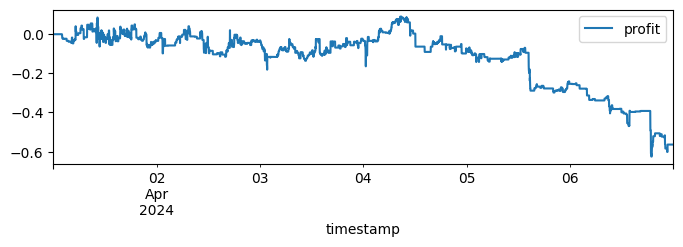

In [355]:
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

248


<AxesSubplot:xlabel='timestamp'>

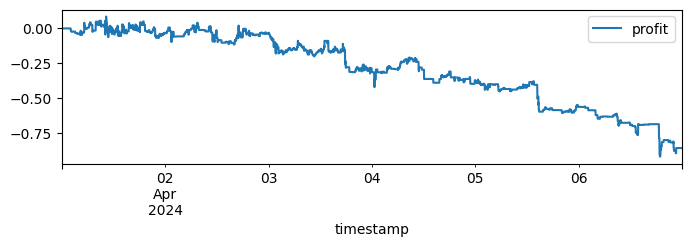

In [351]:
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

458


<AxesSubplot:xlabel='timestamp'>

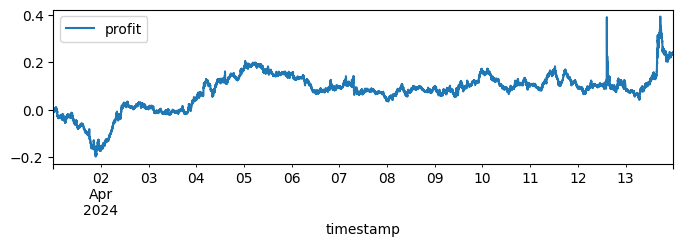

In [308]:
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [28]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(
    window=120, ema_window=30, 
    filter_out_non_gemini_symbol=True, filter_out_reportable_symbols=True)
trading_param = algo.alpha.momentum_reversal.calculate.MomentumReversalTradingParam(
    feature_param, selection_size=1, rebalance_interval_minutes=4*60)

In [29]:
str(feature_param)

'window: 120, ema_window: 30, filter_out_non_gemini_symbol: True, filter_out_reportable_symbols: True'

In [30]:
import algo.feature.util.research
importlib.reload(algo.feature.util.research)

<module 'algo.feature.util.research' from '/Users/junlim/projects/jitter_recovery/algo/feature/util/research.py'>

In [31]:
algo.alpha.momentum_reversal.research.get_trading_label_for_caching(trading_param)

'trading/(momentum_reversal_trading_w_gemini_coins_only)_feature_param(window(120)_ema_window(30)_filter_out_non_gemini_symbol(True)_filter_out_reportable_symbols(True))_selection_size(1)_rebalance_interval_minutes(240)'

In [304]:
dfst_trading_reversal = algo.alpha.momentum_reversal.research.get_dfst_trading(dfst_feature, trading_param)

symbol_with_momentums: 40
0 symbol: AAVE-USDT-SWAP: (trading)
1 symbol: AVAX-USDT-SWAP: (trading)
2 symbol: BCH-USDT-SWAP: (trading)
3 symbol: BTC-USDT-SWAP: (trading)
4 symbol: DOGE-USDT-SWAP: (trading)
5 symbol: FET-USDT-SWAP: (trading)
6 symbol: FTM-USDT-SWAP: (trading)
7 symbol: GAL-USDT-SWAP: (trading)
8 symbol: GMT-USDT-SWAP: (trading)
9 symbol: GRT-USDT-SWAP: (trading)
10 symbol: INJ-USDT-SWAP: (trading)
11 symbol: LRC-USDT-SWAP: (trading)
12 symbol: LTC-USDT-SWAP: (trading)
13 symbol: LUNA-USDT-SWAP: (trading)
14 symbol: MASK-USDT-SWAP: (trading)
15 symbol: MKR-USDT-SWAP: (trading)
16 symbol: PEPE-USDT-SWAP: (trading)
17 symbol: REN-USDT-SWAP: (trading)
18 symbol: RNDR-USDT-SWAP: (trading)
19 symbol: SNX-USDT-SWAP: (trading)
20 symbol: STORJ-USDT-SWAP: (trading)
21 symbol: UNI-USDT-SWAP: (trading)
22 symbol: USDC-USDT-SWAP: (trading)
23 symbol: YFI-USDT-SWAP: (trading)
24 symbol: ZRX-USDT-SWAP: (trading)
25 symbol: API3-USDT-SWAP: (trading)
26 symbol: GALA-USDT-SWAP: (trading)


458


<AxesSubplot:xlabel='timestamp'>

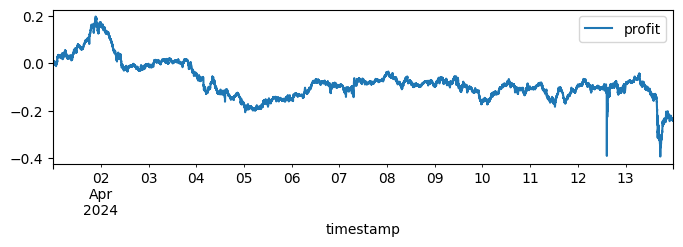

In [305]:
print(len(dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna()))
dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [35]:
print(1696. * 0.01 * 0.05)

0.8480000000000001


In [33]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(
    window=120, ema_window=30, 
    filter_out_non_gemini_symbol=True, filter_out_reportable_symbols=True)
trading_param = algo.alpha.momentum_reversal.calculate.MomentumReversalTradingParam(
    feature_param, selection_size=1, rebalance_interval_minutes=1*60)

1696


<AxesSubplot:xlabel='timestamp'>

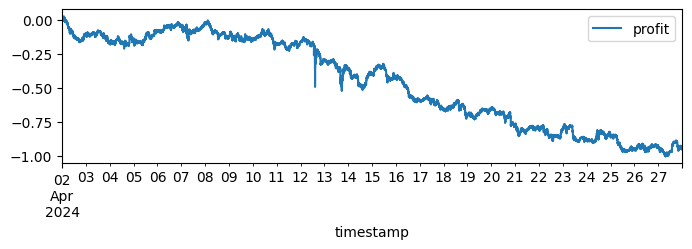

In [34]:
dfst_trading_reversal = algo.cache.read_df(
    label = algo.alpha.momentum_reversal.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-02', 
    date_str_to='2024-04-28',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna()))
dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [ ]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(
    window=120, ema_window=30, 
    filter_out_non_gemini_symbol=True, filter_out_reportable_symbols=True)
trading_param = algo.alpha.momentum_reversal.calculate.MomentumReversalTradingParam(
    feature_param, selection_size=1, rebalance_interval_minutes=2*60)

961


<AxesSubplot:xlabel='timestamp'>

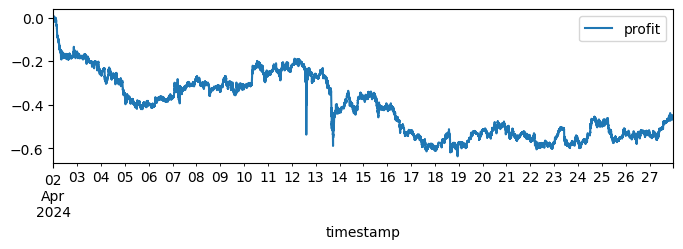

In [27]:
dfst_trading_reversal = algo.cache.read_df(
    label = algo.alpha.momentum_reversal.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-02', 
    date_str_to='2024-04-28',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna()))
dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [ ]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(
    window=120, ema_window=30, 
    filter_out_non_gemini_symbol=True, filter_out_reportable_symbols=True)
trading_param = algo.alpha.momentum_reversal.calculate.MomentumReversalTradingParam(
    feature_param, selection_size=1, rebalance_interval_minutes=4*60)

508


<AxesSubplot:xlabel='timestamp'>

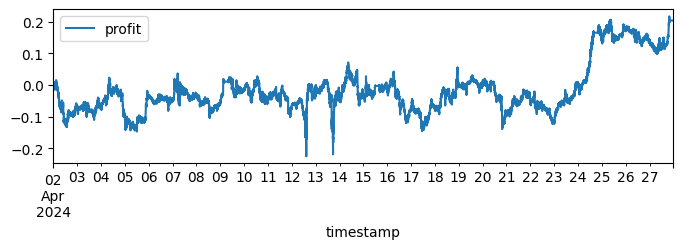

In [32]:
dfst_trading_reversal = algo.cache.read_df(
    label = algo.alpha.momentum_reversal.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-02', 
    date_str_to='2024-04-28',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna()))
dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [157]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(window=180, ema_window=30)
trading_param = algo.alpha.momentum_reversal.calculate.MomentumReversalTradingParam(
    feature_param, selection_size=1, rebalance_interval_minutes=4*60)
dfst_trading_reversal = algo.alpha.momentum_reversal.research.get_dfst_trading(dfst_feature, trading_param)

symbol_with_momentums: 69
0 symbol: AAVEUSD: (trading)
1 symbol: ALIUSD: (trading)
2 symbol: ANKRUSD: (trading)
3 symbol: AVAXUSD: (trading)
4 symbol: AXSUSD: (trading)
5 symbol: BCHUSD: (trading)
6 symbol: CTXUSD: (trading)
7 symbol: DAIUSD: (trading)
8 symbol: ELONUSD: (trading)
9 symbol: ERNUSD: (trading)
10 symbol: FTMUSD: (trading)
11 symbol: GALUSD: (trading)
12 symbol: HNTUSD: (trading)
13 symbol: JAMUSD: (trading)
14 symbol: LPTUSD: (trading)
15 symbol: LTCUSD: (trading)
16 symbol: LUNAUSD: (trading)
17 symbol: MASKUSD: (trading)
18 symbol: PEPEUSD: (trading)
19 symbol: QRDOUSD: (trading)
20 symbol: RAREUSD: (trading)
21 symbol: RENUSD: (trading)
22 symbol: SAMOUSD: (trading)
23 symbol: SHIBUSD: (trading)
24 symbol: ZBCUSD: (trading)
25 symbol: AMPUSD: (trading)
26 symbol: API3USD: (trading)
27 symbol: BATUSD: (trading)
28 symbol: CUBEUSD: (trading)
29 symbol: GMTUSD: (trading)
30 symbol: INJUSD: (trading)
31 symbol: IOTXUSD: (trading)
32 symbol: LINKUSD: (trading)
33 symbol: M

266


<AxesSubplot:xlabel='timestamp'>

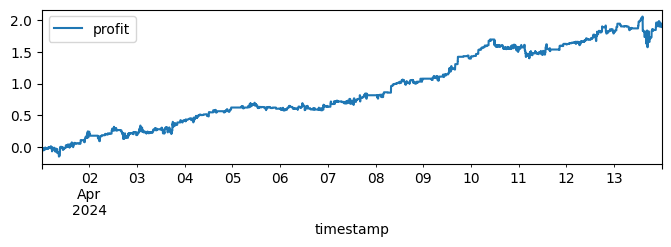

In [158]:
print(len(dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna()))
dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [161]:
2. / 266

0.007518796992481203

In [159]:
8. / 1300

0.006153846153846154

In [137]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(window=180, ema_window=30)
trading_param = algo.alpha.momentum_reversal.calculate.MomentumReversalTradingParam(
    feature_param, selection_size=1, rebalance_interval_minutes=3*60)

In [140]:
dfst_trading_reversal = algo.cache.read_df(
    label = algo.alpha.momentum_reversal.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.BINANCE,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-06', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna()))
dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

AttributeError: 'DataFrame' object has no attribute 'position_changed'

1012


<AxesSubplot:xlabel='timestamp'>

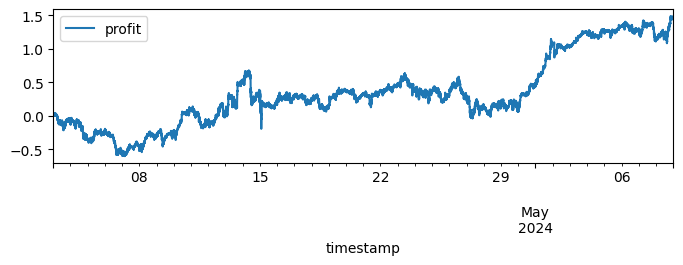

In [138]:
dfst_trading_reversal = algo.cache.read_df(
    label = algo.alpha.momentum_reversal.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.BITHUMB,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.ORDERBOOK_LEVEL1,
    date_str_from='2024-04-03', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna()))
dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [116]:
dfst_trading_reversal = algo.alpha.momentum_reversal.research.get_dfst_trading(dfst_feature, trading_param)

symbol_with_momentums: 43
0 symbol: AAVEUSD: (trading)
1 symbol: ALIUSD: (trading)
2 symbol: AMPUSD: (trading)
3 symbol: ANKRUSD: (trading)
4 symbol: BCHUSD: (trading)
5 symbol: CTXUSD: (trading)
6 symbol: CUBEUSD: (trading)
7 symbol: ELONUSD: (trading)
8 symbol: FETUSD: (trading)
9 symbol: GALAUSD: (trading)
10 symbol: GMTUSD: (trading)
11 symbol: HNTUSD: (trading)
12 symbol: JAMUSD: (trading)
13 symbol: LUNAUSD: (trading)
14 symbol: MASKUSD: (trading)
15 symbol: MKRUSD: (trading)
16 symbol: OXTUSD: (trading)
17 symbol: PEPEUSD: (trading)
18 symbol: QRDOUSD: (trading)
19 symbol: RAREUSD: (trading)
20 symbol: RENUSD: (trading)
21 symbol: SAMOUSD: (trading)
22 symbol: ZBCUSD: (trading)
23 symbol: API3USD: (trading)
24 symbol: BATUSD: (trading)
25 symbol: DOGEUSD: (trading)
26 symbol: ERNUSD: (trading)
27 symbol: LTCUSD: (trading)
28 symbol: XTZUSD: (trading)
29 symbol: IOTXUSD: (trading)
30 symbol: LDOUSD: (trading)
31 symbol: SKLUSD: (trading)
32 symbol: UNIUSD: (trading)
33 symbol: CH

In [ ]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(window=180, ema_window=30)
trading_param = algo.alpha.momentum_reversal.calculate.MomentumReversalTradingParam(
    feature_param, selection_size=2, rebalance_interval_minutes=3*60)

In [76]:
dfst_trading_reversal = algo.alpha.momentum_reversal.research.get_dfst_trading(dfst_feature, trading_param)

symbol_with_momentums: 60
0 symbol: AAVEUSD: (trading)
1 symbol: ALIUSD: (trading)
2 symbol: AMPUSD: (trading)
3 symbol: ANKRUSD: (trading)
4 symbol: API3USD: (trading)
5 symbol: AXSUSD: (trading)
6 symbol: BCHUSD: (trading)
7 symbol: CTXUSD: (trading)
8 symbol: CUBEUSD: (trading)
9 symbol: ELONUSD: (trading)
10 symbol: ERNUSD: (trading)
11 symbol: FETUSD: (trading)
12 symbol: FTMUSD: (trading)
13 symbol: GALAUSD: (trading)
14 symbol: GMTUSD: (trading)
15 symbol: HNTUSD: (trading)
16 symbol: INJUSD: (trading)
17 symbol: JAMUSD: (trading)
18 symbol: LRCUSD: (trading)
19 symbol: LTCUSD: (trading)
20 symbol: LUNAUSD: (trading)
21 symbol: MASKUSD: (trading)
22 symbol: MKRUSD: (trading)
23 symbol: OXTUSD: (trading)
24 symbol: PAXGUSD: (trading)
25 symbol: PEPEUSD: (trading)
26 symbol: QRDOUSD: (trading)
27 symbol: RAREUSD: (trading)
28 symbol: RENUSD: (trading)
29 symbol: SAMOUSD: (trading)
30 symbol: SANDUSD: (trading)
31 symbol: SHIBUSD: (trading)
32 symbol: STORJUSD: (trading)
33 symbol:

1860


<AxesSubplot:xlabel='timestamp'>

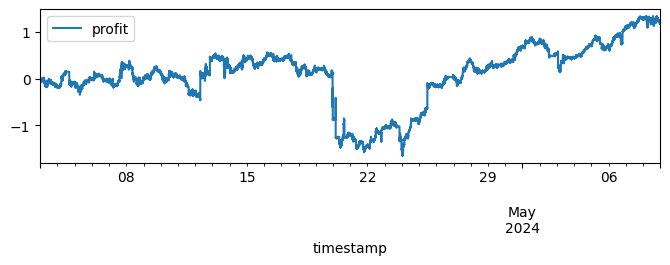

In [93]:
dfst_trading_reversal = algo.cache.read_df(
    label = algo.alpha.momentum_reversal.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.CEX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-03', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna()))
dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

1977


<AxesSubplot:xlabel='timestamp'>

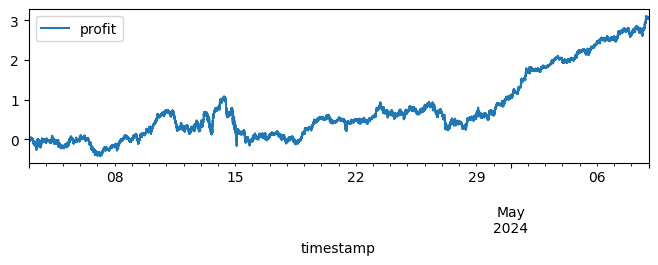

In [92]:
dfst_trading_reversal = algo.cache.read_df(
    label = algo.alpha.momentum_reversal.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.BITHUMB,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.ORDERBOOK_LEVEL1,
    date_str_from='2024-04-03', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna()))
dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [91]:
dfst_trading_reversal.columns

Index(['profit', 'value', 'position_changed'], dtype='object')

299


<AxesSubplot:xlabel='timestamp'>

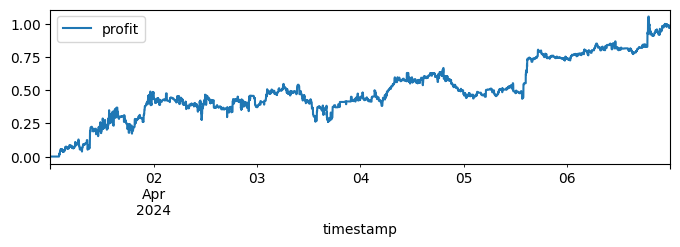

In [78]:
print(len(dfst_trading_reversal[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [ ]:
df_feature_trading['profit'] = df_feature_trading.value.pct_change() * df_feature_trading.in_position.shift()

In [84]:
dfst_trading_reversal[
    (dfst_trading_reversal.profit.fillna(0) != 0) &
    (dfst_trading_reversal.in_position.shift() == 1)
][['profit']].sum()

profit    0.612224
dtype: float64

In [85]:
dfst_trading_reversal[
    (dfst_trading_reversal.profit.fillna(0) != 0) &
    (dfst_trading_reversal.in_position.shift() == -1)
][['profit']].sum()

profit    0.390446
dtype: float64

In [86]:
dfst_trading_reversal[
    (dfst_trading_reversal.profit.fillna(0) != 0) & 
    (dfst_trading_reversal.in_position.shift() == 1)
][['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
SKLUSD,-0.052969
IOTXUSD,-0.031196
FETUSD,-0.030450
ANKRUSD,-0.027120
RENUSD,-0.026086
IMXUSD,-0.020808
LDOUSD,-0.016707
BCHUSD,-0.015592
AMPUSD,-0.008114


In [79]:
dfst_trading_reversal[dfst_trading_reversal.profit.fillna(0) != 0][['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
IOTXUSD,-0.103343
BCHUSD,-0.094642
LTCUSD,-0.076608
SKLUSD,-0.062445
LDOUSD,-0.036158
FETUSD,-0.030450
IMXUSD,-0.020808
MKRUSD,-0.013420
PAXGUSD,-0.011057


In [97]:
symbol_investigate = 'QRDOUSD'

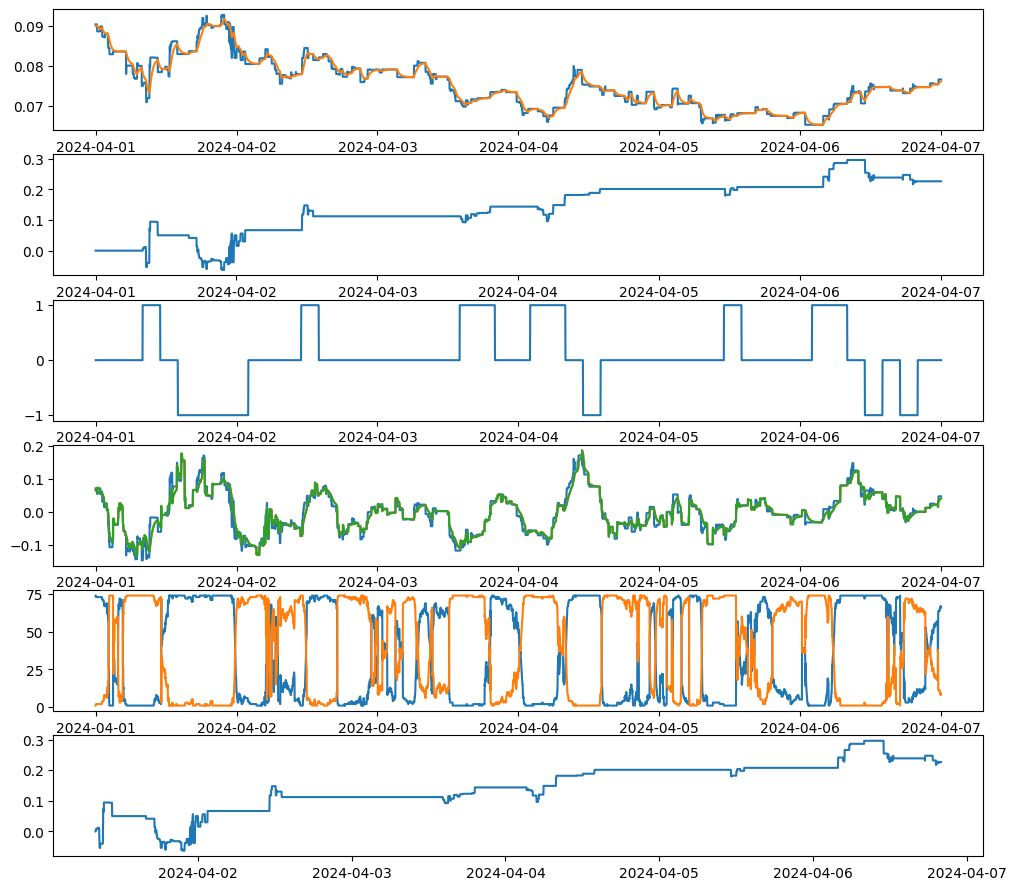

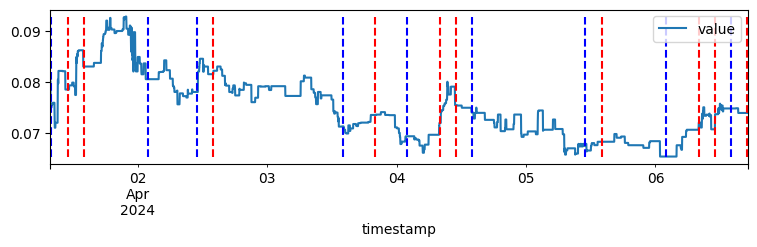

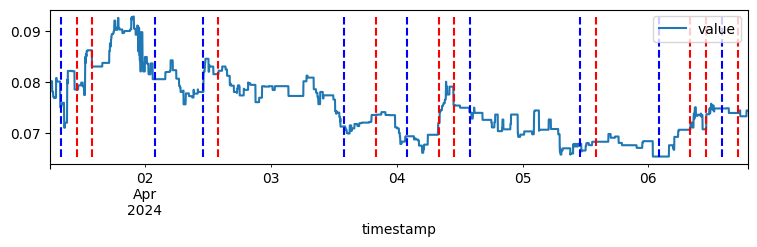

In [99]:
df_feature, df_trading = algo.alpha.momentum_common.research.investigate_symbol(
    dfst_feature, symbol_investigate, algo.alpha.momentum_reversal.research.add_trading_columns, trading_param, figsize=(12, 11))

303


<AxesSubplot:xlabel='timestamp'>

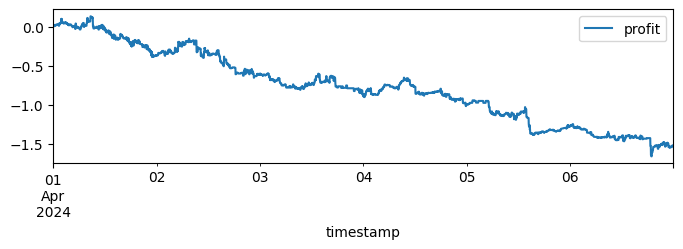

In [71]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.GEMINI,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-01', 
    date_str_to='2024-04-07',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading[(dfst_trading.position_changed != 0)].dropna()))
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [122]:
dfst_trading_reversal = algo.alpha.momentum_reversal.research.get_dfst_trading(dfst_feature, trading_param)

symbol_with_momentums: 60
0 symbol: AIDOGE-USDT-SWAP: (trading)
1 symbol: APT-USDT-SWAP: (trading)
2 symbol: CEL-USDT-SWAP: (trading)
3 symbol: CETUS-USDT-SWAP: (trading)
4 symbol: CFX-USDT-SWAP: (trading)
5 symbol: CORE-USDT-SWAP: (trading)
6 symbol: DGB-USDT-SWAP: (trading)
7 symbol: ETHFI-USDT-SWAP: (trading)
8 symbol: GFT-USDT-SWAP: (trading)
9 symbol: JOE-USDT-SWAP: (trading)
10 symbol: JTO-USDT-SWAP: (trading)
11 symbol: JUP-USDT-SWAP: (trading)
12 symbol: LOOKS-USDT-SWAP: (trading)
13 symbol: LQTY-USDT-SWAP: (trading)
14 symbol: MEME-USDT-SWAP: (trading)
15 symbol: RSR-USDT-SWAP: (trading)
16 symbol: RVN-USDT-SWAP: (trading)
17 symbol: STX-USDT-SWAP: (trading)
18 symbol: SWEAT-USDT-SWAP: (trading)
19 symbol: TURBO-USDT-SWAP: (trading)
20 symbol: USDC-USDT-SWAP: (trading)
21 symbol: VELO-USDT-SWAP: (trading)
22 symbol: VRA-USDT-SWAP: (trading)
23 symbol: YGG-USDT-SWAP: (trading)



KeyboardInterrupt



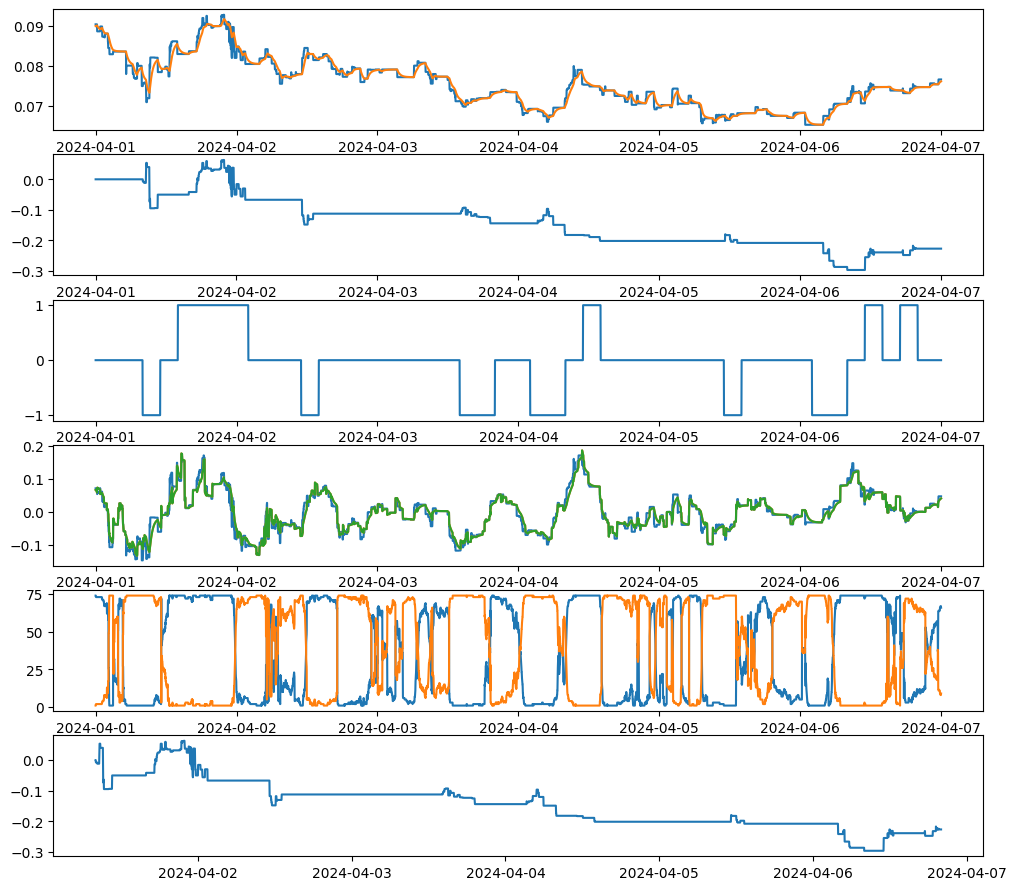

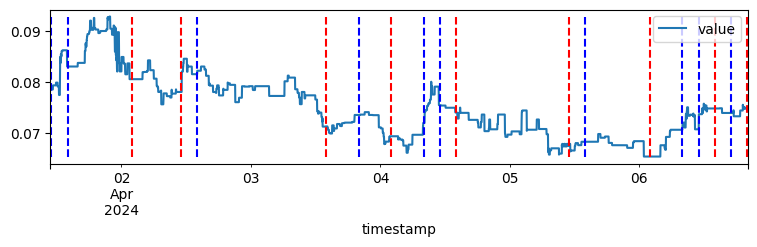

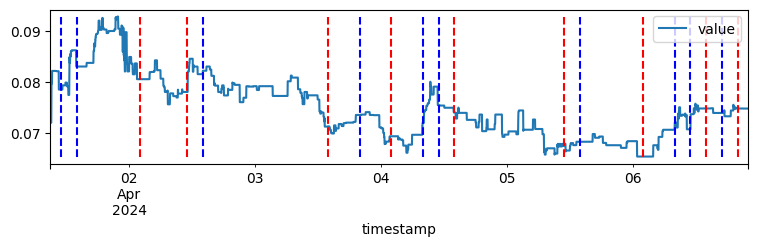

In [100]:
df_feature, df_trading = algo.alpha.momentum_common.research.investigate_symbol(
    dfst_feature, symbol_investigate, algo.alpha.momentum.research.add_trading_columns, trading_param, figsize=(12, 11))

In [129]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(window=360, ema_window=60)
trading_param = algo.alpha.momentum_reversal.calculate.MomentumReversalTradingParam(
    feature_param, selection_size=1, rebalance_interval_minutes=6*60)

942


<AxesSubplot:xlabel='timestamp'>

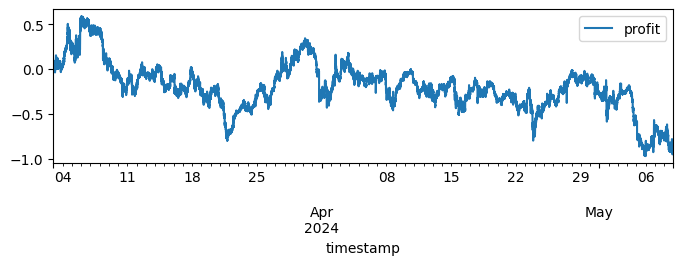

In [133]:
dfst_trading_reversal = algo.cache.read_df(
    label = algo.alpha.momentum_reversal.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-03-03', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna()))
dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

446


<AxesSubplot:xlabel='timestamp'>

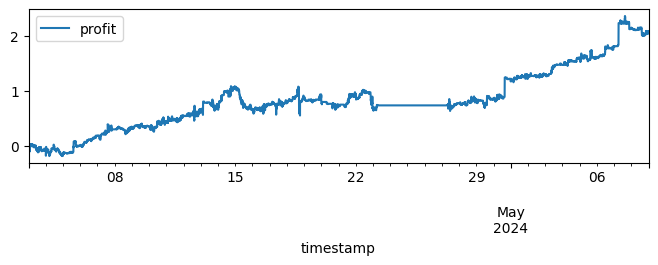

In [134]:
dfst_trading_reversal = algo.cache.read_df(
    label = algo.alpha.momentum_reversal.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.GEMINI,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-03', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna()))
dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [119]:
dfst_trading_reversal = algo.alpha.momentum_reversal.research.get_dfst_trading(dfst_feature, trading_param)

symbol_with_momentums: 43
0 symbol: AAVEUSD: (trading)
1 symbol: ALIUSD: (trading)
2 symbol: AMPUSD: (trading)
3 symbol: ANKRUSD: (trading)
4 symbol: BCHUSD: (trading)
5 symbol: CTXUSD: (trading)
6 symbol: CUBEUSD: (trading)
7 symbol: ELONUSD: (trading)
8 symbol: FETUSD: (trading)
9 symbol: GALAUSD: (trading)
10 symbol: GMTUSD: (trading)
11 symbol: HNTUSD: (trading)
12 symbol: JAMUSD: (trading)
13 symbol: LUNAUSD: (trading)
14 symbol: MASKUSD: (trading)
15 symbol: MKRUSD: (trading)
16 symbol: OXTUSD: (trading)
17 symbol: PEPEUSD: (trading)
18 symbol: QRDOUSD: (trading)
19 symbol: RAREUSD: (trading)
20 symbol: RENUSD: (trading)
21 symbol: SAMOUSD: (trading)
22 symbol: ZBCUSD: (trading)
23 symbol: API3USD: (trading)
24 symbol: BATUSD: (trading)
25 symbol: DOGEUSD: (trading)
26 symbol: ERNUSD: (trading)
27 symbol: LTCUSD: (trading)
28 symbol: XTZUSD: (trading)
29 symbol: IOTXUSD: (trading)
30 symbol: LDOUSD: (trading)
31 symbol: SKLUSD: (trading)
32 symbol: UNIUSD: (trading)
33 symbol: CH

82


<AxesSubplot:xlabel='timestamp'>

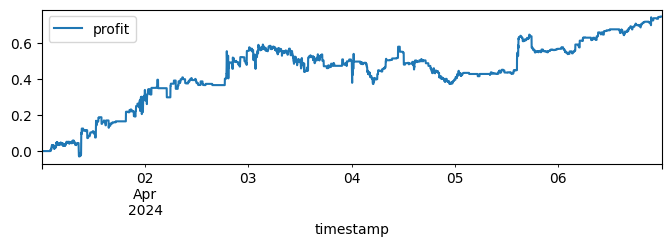

In [120]:
print(len(dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna()))
dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [102]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(window=360, ema_window=60)
trading_param = algo.alpha.momentum_reversal.calculate.MomentumReversalTradingParam(
    feature_param, selection_size=2, rebalance_interval_minutes=6*60)

947


<AxesSubplot:xlabel='timestamp'>

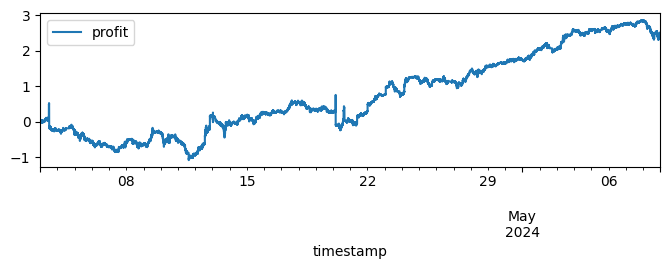

In [106]:
dfst_trading_reversal = algo.cache.read_df(
    label = algo.alpha.momentum_reversal.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.CEX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-03', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna()))
dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

835


<AxesSubplot:xlabel='timestamp'>

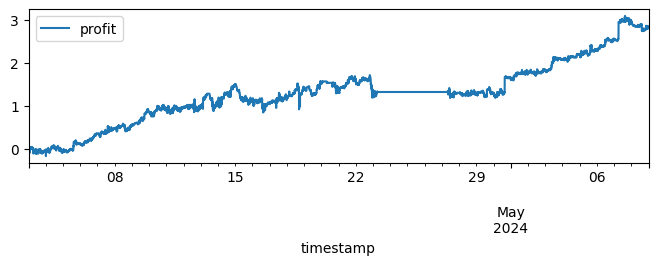

In [103]:
dfst_trading_reversal = algo.cache.read_df(
    label = algo.alpha.momentum_reversal.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.GEMINI,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-03', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)
print(len(dfst_trading_reversal[(dfst_trading_reversal.position_changed != 0)].dropna()))
dfst_trading_reversal[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

## single symbol

In [1064]:
import algo.alpha.momentum.calculate
importlib.reload(algo.alpha.momentum.calculate)
import algo.alpha.momentum.research
importlib.reload(algo.alpha.momentum.research)
import algo.alpha.momentum.research
importlib.reload(algo.alpha.momentum.research)

<module 'algo.alpha.momentum.research' from '/Users/junlim/projects/jitter_recovery/algo/alpha/momentum/research.py'>

In [41]:
symbol_investigate = 'ERNUSD'

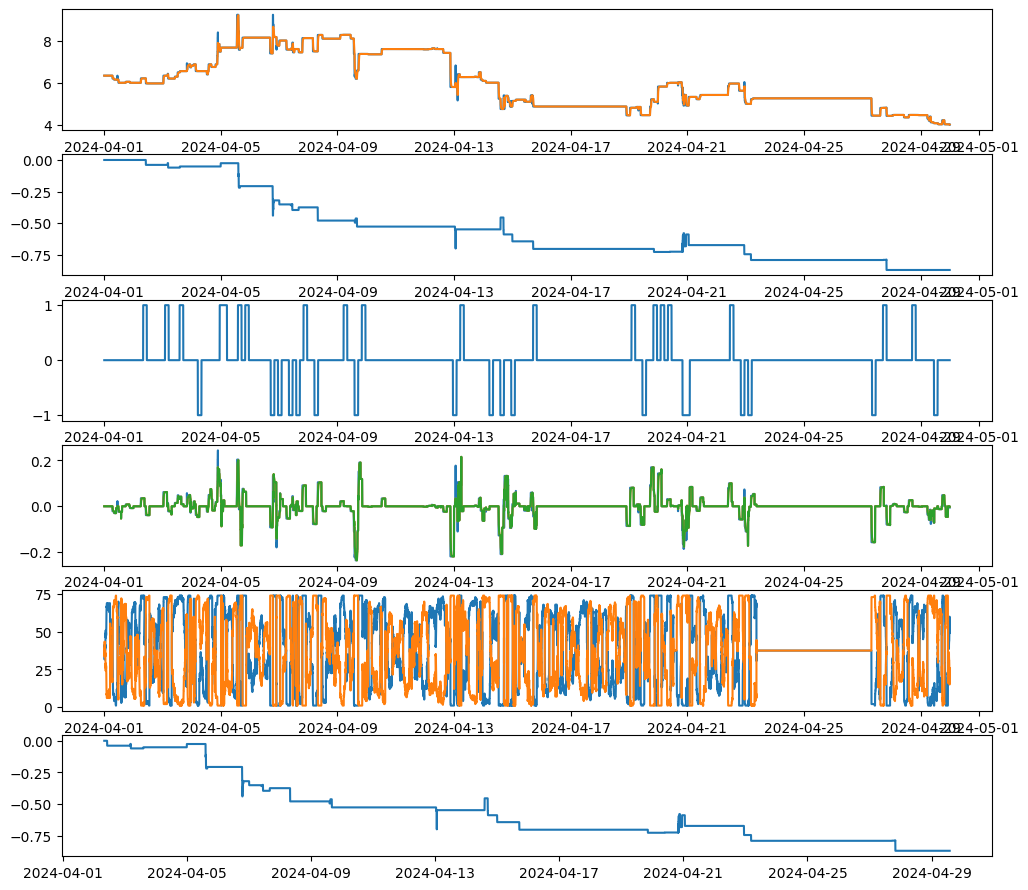

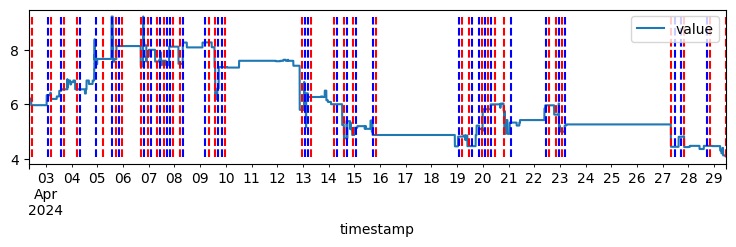

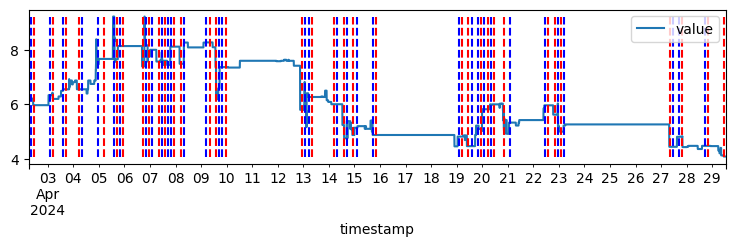

In [42]:
df_feature, df_trading = algo.alpha.momentum.research.investigate_symbol(
    dfst_feature, symbol_investigate, trading_param, figsize=(12, 11))

In [39]:
df_trading[(df_trading.position_changed != 0)][['value', 'in_position', 'position_changed', 'profit_raw', 'profit']].dropna()

,value,in_position,position_changed,profit_raw,profit
timestamp,,,,,
2024-04-01 05:00:00-04:00,0.08360,-1,-1.0,0.0,0.0
2024-04-01 11:00:00-04:00,0.07848,0,1.0,-0.0,-0.0
2024-04-01 14:00:00-04:00,0.08298,1,1.0,0.0,0.0
2024-04-01 17:00:00-04:00,0.08369,0,-1.0,0.0,0.0
2024-04-01 20:00:00-04:00,0.08966,1,1.0,0.0,0.0
...,...,...,...,...,...
2024-04-27 17:00:00-04:00,0.04064,0,1.0,-0.0,-0.0
2024-04-28 17:00:00-04:00,0.03909,-1,-1.0,0.0,0.0
2024-04-28 20:00:00-04:00,0.04087,0,1.0,-0.0,-0.0


In [40]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if row['symbol'] != symbol_investigate: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-04-01 05:00:00-04:00, QRDOUSD, 0.0836, position_changed: -1.0
2024-04-01 11:00:00-04:00, QRDOUSD, 0.07848, position_changed: 1.0
2024-04-01 14:00:00-04:00, QRDOUSD, 0.08298, position_changed: 1.0
2024-04-01 17:00:00-04:00, QRDOUSD, 0.08369, position_changed: -1.0
2024-04-01 20:00:00-04:00, QRDOUSD, 0.08966, position_changed: 1.0
2024-04-01 23:00:00-04:00, QRDOUSD, 0.08524, position_changed: -1.0
2024-04-02 08:00:00-04:00, QRDOUSD, 0.07772, position_changed: -1.0
2024-04-02 11:00:00-04:00, QRDOUSD, 0.078, position_changed: 1.0
2024-04-02 14:00:00-04:00, QRDOUSD, 0.08148, position_changed: 1.0
2024-04-02 17:00:00-04:00, QRDOUSD, 0.07799, position_changed: -1.0
2024-04-03 08:00:00-04:00, QRDOUSD, 0.08081, position_changed: 1.0
2024-04-03 11:00:00-04:00, QRDOUSD, 0.07734, position_changed: -1.0
2024-04-03 14:00:00-04:00, QRDOUSD, 0.07126, position_changed: -1.0
2024-04-03 17:00:00-04:00, QRDOUSD, 0.07188, position_changed: 1.0
2024-04-04 02:00:00-04:00, QRDOUSD, 0.06933, position_chan